# Impact on Stock Returns:  
## Data Cleaning  

This Jupyter Notebook is designed to address the issues identified during the initial exploratory data analysis (EDA).  

In this notebook, we will clean the dataset by handling missing values, removing inconsistencies, correcting formatting issues, and addressing outliers. The objective is to prepare a refined and structured dataset that is ready for further analysis in subsequent notebooks.  

## About the Process  

Data cleaning is a crucial step to ensure that the insights derived from the dataset are reliable and accurate. We will focus on strategies to improve data quality, including:  
- Removing or imputing missing values.  
- Standardizing formats.  
- Resolving anomalies and inconsistencies.  
- Ensuring the dataset is ready for deeper exploration and modeling.  

This notebook sets the foundation for the next steps in the pipeline, including post-cleaning EDA and machine learning tasks.  


## Let's get started

### Step 1: Import Required Libraries and dataframes
Before proceeding, ensure all necessary libraries and the dataset itself are imported for smooth execution.

In [3]:
import warnings
warnings.filterwarnings("ignore")

import time
import pandas as pd
import numpy as np

df = pd.read_csv("../../data/raw/Impact_on_Stock_Returns/full_dataset-release.csv")
df2 = pd.read_csv("../../data/raw/Impact_on_Stock_Returns/reduced_dataset-release.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395450 entries, 0 to 1395449
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1102013 non-null  object 
 1   TWEET              1395398 non-null  object 
 2   STOCK              862231 non-null   object 
 3   DATE               862231 non-null   object 
 4   LAST_PRICE         862231 non-null   float64
 5   1_DAY_RETURN       862231 non-null   float64
 6   2_DAY_RETURN       862231 non-null   float64
 7   3_DAY_RETURN       862231 non-null   float64
 8   7_DAY_RETURN       862231 non-null   float64
 9   PX_VOLUME          862231 non-null   float64
 10  VOLATILITY_10D     862130 non-null   float64
 11  VOLATILITY_30D     862184 non-null   float64
 12  LSTM_POLARITY      661102 non-null   float64
 13  TEXTBLOB_POLARITY  367665 non-null   float64
dtypes: float64(10), object(4)
memory usage: 149.1+ MB


### Step 2: Handle Missing Values and Duplicate Entries  

In this step, we will refine the dataset by addressing missing values and removing duplicate records. Additionally, we will compute the count and percentage distribution of stock occurrences to better understand the data.  

In [5]:
df_temp = df.copy()
df_temp = df_temp.dropna()
df_temp = df_temp.drop_duplicates()

count = df_temp['STOCK'].value_counts()
perc = count/count.sum()
dstr = pd.DataFrame({"Count": count, "Percentage": perc}).reset_index()
dstr

,STOCK,Count,Percentage
0,Ford,52198,0.141989
1,Facebook,40837,0.111085
2,Google,33697,0.091663
3,Next,32606,0.088695
4,Apple,27940,0.076002
...,...,...,...
96,Volkswagen,18,0.000049
97,Equinor,12,0.000033
98,CVS Health,11,0.000030
99,21CF,4,0.000011


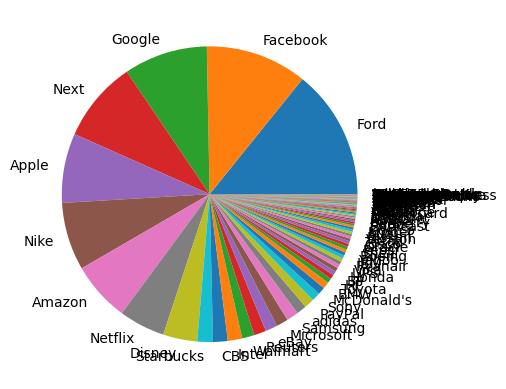

In [4]:
import matplotlib.pyplot as plt
plt.pie(dstr['Count'], labels = dstr['STOCK'])
plt.show()

### Step 3: Categorize Stocks Based on Tweet Distribution  

In this step, we will categorize the stocks into three groups based on their share of tweets:  
- **Top 5 Stocks**: Stocks that account for approximately 50% of the tweet share.  
- **Middle 25% Stocks**: Stocks that fall within the next quartile range based on tweet distribution.  
- **Bottom 25% Stocks**: Stocks below the threshold of the top quartiles, providing insight into less-discussed companies.  

This categorization will help us analyze the data more systematically, focusing on the distribution and significance of tweets across different stock categories.  

In [6]:
# Top 5 stocks (~50% share of tweets)
TOP_STOCKS = dstr['STOCK'].head().to_list()

# Middle 25% 
MID_STOCKS = dstr['STOCK'].iloc[5:].head().to_list()

# Bottom 25% (Below Starbucks)
BOT_STOCKS = dstr['STOCK'].iloc[10:].to_list()

### Step 4: Segment Stocks and Refine DataFrames  

In this step, we will segment the stocks into three categories: top, middle, and bottom stocks. For each segment, we will refine the associated dataframes by filtering stocks and tweets that belong to the respective categories.  

We will also calculate the expected cleaned dataframe size by removing entries with missing values in the column `Unnamed: 0`. This step ensures that each segment is prepared for detailed analysis and further exploration in subsequent stages.  

In [8]:
# COL = ['Ford', 'Facebook', 'Google']
df_top = df[df['STOCK'].isin(TOP_STOCKS) | df['TWEET'].isin(TOP_STOCKS)]
df_top = df_top.reset_index(drop=True)
l1 = len(df_top)
l2 = len(df_top[df_top['Unnamed: 0'].isnull()])
df_top[df_top['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

df_mid = df[df['STOCK'].isin(MID_STOCKS) | df['TWEET'].isin(MID_STOCKS)]
df_mid = df_mid.reset_index(drop=True)
l1 = len(df_mid)
l2 = len(df_mid[df_mid['Unnamed: 0'].isnull()])
df_mid[df_mid['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

df_bot = df[df['STOCK'].isin(BOT_STOCKS) | df['TWEET'].isin(BOT_STOCKS)]
df_bot = df_bot.reset_index(drop=True)
l1 = len(df_bot)
l2 = len(df_bot[df_bot['Unnamed: 0'].isnull()])
df_bot[df_bot['Unnamed: 0'].isnull()]
print(f"Expected cleaned df size: {l1 - l2}")

Expected cleaned df size: 187342
Expected cleaned df size: 89848
Expected cleaned df size: 90622


### Step 5: Fix Misaligned Rows in DataFrames  

In this step, we define and apply a function to correct misaligned rows in the dataframes. The misalignment might have occurred due to missing values or shifted entries. The function, `fix_misalignment`, adjusts the rows by shifting non-NaN values to the appropriate columns and removes rows with invalid entries (e.g., rows where the first column is NaN).  

This operation is applied to each of the segmented dataframes: **Top**, **Middle**, and **Bottom** stocks. The runtime for each operation is measured to account for the computational cost of this step, which is essential due to the large size of the dataset.  

By cleaning misaligned rows, we ensure the integrity and consistency of the data, preparing it for further analysis in the subsequent steps.  

In [9]:
# Function to fix misalignment
def fix_misalignment(df):
    # Copy the original DataFrame to avoid altering it directly
    df = df.copy()

    # Create a mask where the first column is NaN
    mask = df.iloc[:, 0].isna()

    # Iterate over rows where the mask is True
    for idx in df[mask].index.tolist():  # Use a list of indices to avoid dynamic changes
        # Get the previous row index
        previous_idx = idx - 1
        
        # Ensure the previous index is valid and within bounds
        if previous_idx in df.index:  
            for col in range(1, len(df.columns)):
                # Check if the current value is non-NaN
                if not pd.isna(df.iloc[idx, col]):
                    # Ensure the column is within bounds of the previous row
                    if col+1 < len(df.columns):
                        df.iloc[previous_idx, col+1] = df.iloc[idx, col]

    # Drop rows where the first column is NaN
    df = df[~mask]

    return df
# 49 MINUTE RUNTIME

# BOT
start_time = time.time()

df_bot_cleaned = fix_misalignment(df_bot)

end_time = time.time()
runtime = end_time - start_time
print(f'RUNTIME: {runtime:.2f} seconds')

# MID
start_time = time.time()

df_mid_cleaned = fix_misalignment(df_mid)

end_time = time.time()
runtime = end_time - start_time
print(f'RUNTIME: {runtime:.2f} seconds')

# TOP
start_time = time.time()

df_top_cleaned = fix_misalignment(df_top)

end_time = time.time()
runtime = end_time - start_time
print(f'RUNTIME: {runtime:.2f} seconds')

RUNTIME: 563.29 seconds
RUNTIME: 602.31 seconds
RUNTIME: 1774.62 seconds


### Step 6: Final Refinement of Cleaned DataFrames  

In this step, we will finalize the preparation of the cleaned dataframes for each stock category (Top, Middle, and Bottom):  
- **Reset the Index**: Ensures the dataframes have clean, sequential indices after data cleaning.
- **Drop the 'Unnamed: 0' Column**: Removes this unnecessary column to declutter the dataset.

These final touches will prepare the dataframes for in-depth exploratory or machine learning tasks in subsequent notebooks.

In [10]:
df_top_cleaned = df_top_cleaned.reset_index(drop=True)
df_top_cleaned = df_top_cleaned.drop('Unnamed: 0', axis=1)
df_top_cleaned

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,RT @IndiaHistorypic: 1994::Young @sundarpichai...,Google,31/01/2017,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,0.0000
1,"RT @Google: ""If you have the feeling that some...",Google,31/01/2017,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,-0.5500
2,"RT @IBMWatson: Welcome @Apple, #ACLU, #AAAI, @...",Apple,31/01/2017,121.35,0.002307,0.004944,0.004944,-0.011372,49200993.0,9.114,8.417,1.0,1.0000
3,RT @ColMorrisDavis: My family owned a @Ford de...,Ford,31/01/2017,12.36,0.000809,0.010518,0.010518,0.020227,46974479.0,26.321,27.647,1.0,0.0000
4,RT @ThatBitchFromNJ: Google's sponsored ad for...,Google,31/01/2017,820.19,0.004438,0.030286,0.030286,0.035772,2020180.0,21.549,14.953,-1.0,-0.1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187337,RT @time2trade2: @McAllisterDen Trump called f...,Ford,30/09/2018,9.25,0.000000,0.000000,-0.002162,0.064865,30987233.0,23.492,22.989,1.0,0.0000
187338,Thanks Google\r\r\r\r\r\r\n\r\r\r\r\r\r\nHey L...,Ford,30/09/2018,9.25,0.000000,0.000000,-0.002162,0.064865,30987233.0,23.492,22.989,1.0,0.0000
187339,RT @rmbyrne: Do you have any colleagues who th...,Google,30/09/2018,1207.08,0.000000,0.000000,0.000232,-0.028962,1780759.0,15.005,17.588,-1.0,-0.0625
187340,RT @AnnCoulter: Item No. 3 for FBI to investig...,Ford,30/09/2018,9.25,0.000000,0.000000,-0.002162,0.064865,30987233.0,23.492,22.989,-1.0,0.0000


In [11]:
df_mid_cleaned = df_mid_cleaned.reset_index(drop=True)
df_mid_cleaned = df_mid_cleaned.drop('Unnamed: 0', axis=1)
df_mid_cleaned

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,"RT @nikitakhara: Thank you, @Starbucks CEO for...",Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,-1.0,0.800000
1,RT @cultcommoncore: Dumping @Starbucks\r\r\r\r...,Starbucks,31/01/2017,55.22,0.012314,0.016298,0.016298,0.058312,14307985.0,23.916,17.298,-1.0,0.000000
2,@amazon has your back when it comes to food sh...,Netflix,31/01/2017,140.71,0.003624,0.012366,0.012366,-0.004264,4411631.0,27.398,24.135,1.0,1.000000
3,"RT @nia4_trump: So instead of hiring 10,000 un...",Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,1.0,0.000000
4,Hmmm interesting... \r\r\r\r\r\r\nonly @IBM ha...,Amazon,31/01/2017,823.48,0.008379,0.014924,0.014924,-0.001263,3137196.0,13.447,16.992,-1.0,0.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89843,"I'm at Starbucks in Al-Andalus, Al Asimah http...",Starbucks,30/09/2018,56.84,0.000000,0.000000,0.008797,0.010732,8975955.0,17.035,13.123,-1.0,0.000000
89844,RT @suzford: This bodes well! #JulieRapaport n...,Amazon,30/09/2018,2003.0,0.000000,0.000000,0.004983,-0.043929,4085135.0,20.709,22.946,1.0,0.000000
89845,RT @shopWSS: Celebrating 90 years of Mickey Mo...,Nike,30/09/2018,84.72,0.000000,0.000000,-0.002125,0.009797,7452735.0,20.470,20.016,1.0,0.458333
89846,RT @radiodisney: Tune in to the Radio Disney I...,Disney,30/09/2018,116.94,0.000000,0.000000,-0.007696,-0.055926,7366846.0,15.232,13.230,1.0,0.000000


In [12]:
df_bot_cleaned = df_bot_cleaned.reset_index(drop=True)
df_bot_cleaned = df_bot_cleaned.drop('Unnamed: 0', axis=1)
df_bot_cleaned

,TWEET,STOCK,DATE,LAST_PRICE,1_DAY_RETURN,2_DAY_RETURN,3_DAY_RETURN,7_DAY_RETURN,PX_VOLUME,VOLATILITY_10D,VOLATILITY_30D,LSTM_POLARITY,TEXTBLOB_POLARITY
0,@FAME95FM1 Jamaicans make money with @Payoneer...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,-1.0,0.000000
1,@CBSi Jamaicans make money with @Payoneer @Pay...,PayPal,31/01/2017,39.78,0.002011,0.012318,0.012318,0.054801,9100057.0,18.769,16.099,1.0,0.000000
2,@Hitz92fm Jamaicans make money with @Payoneer ...,eBay,31/01/2017,31.83,0.010682,0.021363,0.021363,-0.057807,9469076.0,33.029,22.932,1.0,-0.166667
3,@gawker Jamaicans make money with @Payoneer @P...,CBS,31/01/2017,64.49,-0.001396,0.003877,0.003877,-0.023414,3523867.0,16.338,16.302,1.0,0.000000
4,@Dal_Schnur @DKuzLA @wrightco0704 @psuba98 @Re...,HSBC,31/01/2017,676.4,0.005322,0.016558,0.016558,-0.005322,27693980.0,12.549,15.009,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90617,RT @SyriaArchivist: @ReutersWorld How about Re...,Walmart,30/09/2018,93.91,0.000000,0.000000,0.002343,0.021191,6306274.0,8.702,11.667,-1.0,0.250000
90618,24 Destinations Where You Can Stay\r\r\r\r\r\r...,eBay,30/09/2018,33.02,0.000000,0.000000,0.009691,0.030890,8467405.0,22.738,17.202,1.0,0.000000
90619,"RT @DrKanyuira: In Japan, youths in their mid...",Honda,30/09/2018,3439.0,0.000000,0.000000,-0.009305,0.015121,5554600.0,26.410,22.868,-1.0,-0.063889
90620,RT @Spicywienerprod: The #sexy Roxy Cox Follo...,Reuters,30/09/2018,50.3139,0.000000,0.000000,0.000876,-0.006785,7988967.0,6.838,12.771,1.0,0.000000


### Step 7: Merge Cleaned Dataframes and Visualize Missing Data  

In this step, we will:
1. **Merge All Cleaned Dataframes**: Combine the cleaned dataframes for Top, Middle, and Bottom stocks into a single dataset (`df_cleaned`) while removing duplicate entries.
2. **Visualize Missing Data**: Use a heatmap to analyze and visually inspect any remaining missing values within the `df_top_cleaned` dataframe. This helps identify areas that may require additional cleaning or imputation.

By conducting this step, we ensure that the dataset is unified and ready for further exploration while addressing any residual issues.  

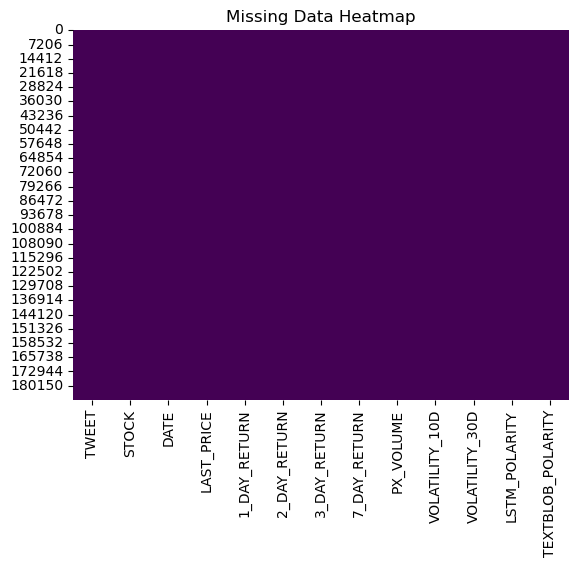

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# join all cleaned dataframes and check for missing values
df_cleaned = pd.concat([df_top_cleaned, df_mid_cleaned, df_bot_cleaned], ignore_index=True)
df_cleaned = df_cleaned.drop_duplicates()

sns.heatmap(df_top_cleaned.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

#### Conclusion  

As we can see from the figure above, there is no missing data remaining in the dataset. The cleaning process has successfully addressed all inconsistencies, making the data ready for further analysis.  

### Step 8: Save the data

The next step is to save the cleaned dataset for use in subsequent notebooks and tasks.

In [24]:
import os

# Define the directory path
current_path = os.getcwd()
cleaned_dir = os.path.join(current_path, r'../../data/processed/Impact_on_Stock_Returns')

try:
    # Check if a file with the same name exists
    if os.path.isfile(cleaned_dir):
        raise OSError(f"A file named '{cleaned_dir}' exists. Remove or rename it.")

    # Create the directory if it doesn't exist
    if not os.path.exists(cleaned_dir):
        os.makedirs(cleaned_dir)
    
    # Save data to the cleaned directory
    df_top_cleaned.to_csv(os.path.join(cleaned_dir, 'df_top_cleaned.csv'), index=False)
    df_mid_cleaned.to_csv(os.path.join(cleaned_dir, 'df_mid_cleaned.csv'), index=False)
    df_bot_cleaned.to_csv(os.path.join(cleaned_dir, 'df_bot_cleaned.csv'), index=False)
    
    df_cleaned.to_csv(os.path.join(cleaned_dir, 'df_cleaned.csv'), index=False)
    print("Data saved successfully!")

except OSError as e:
    print(f"Error: {e}")
    print("Please verify the path and ensure there are no conflicts with existing files or devices.")
except Exception as e:
    print(f"Unexpected Error: {e}")

Data saved successfully!


## To do:   
- Standardizing formats.  
- Resolving anomalies and inconsistencies.  
- Ensuring the dataset is ready for deeper exploration and modeling.  